# Scratch Notebook for Coordinate Systems

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx
import optax

import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista as pv

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real

In [15]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
import c1lgkt.jax.fields.clebsch
from c1lgkt.jax.fields.clebsch import ThetaMapping, ClebschMappingBuilder
from c1lgkt.jax.fields.field_providers import EikonalFieldProvider
from c1lgkt.jax.fields.geometry_handlers import FieldlinePusher, FieldlineArgs, GeometryHandler
import c1lgkt.jax.particles.particle_motion as particle_motion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# %% Test loading equilibrium
%matplotlib inline
eq = Equilibrium.from_eqdfile('./tests/D3D141451.eqd')

In [5]:
# %% Build Clebsch mapping from equilibrium
clebsch_builder = ClebschMappingBuilder()
theta_map, clebsch = clebsch_builder.clebsch_from_equilibrium(eq)

In [6]:
# %% Test serialisation
#eqx.tree_serialise_leaves('./outputs/clebsch_D3D141451.eqx', theta_map)
#theta_map = eqx.tree_deserialise_leaves('./outputs/clebsch_D3D141451.eqx', theta_map)

In [ ]:
# %% Set up eikonal field provider

coefs = np.zeros((2, 4, 6))
coefs[0, 2, 0] = 1.0
coefs[1, 2, 0] = 0.7

theta_x1 = theta_map(theta_map.nulls.x1.rz[0], theta_map.nulls.x1.rz[1])
theta_x2 = theta_map(theta_map.nulls.x2.rz[0], theta_map.nulls.x2.rz[1])

field_provider = EikonalFieldProvider(
    clebsch = clebsch,
    n = jnp.array([3, 3], dtype=int),
    omega = jnp.array([0.0, 0.0]),
    psi0 = jnp.array([0.95*eq.psix, 0.95*eq.psix]),
    psi_scale = jnp.array([0.02*eq.psix, 0.02*eq.psix]),
    theta0 = jnp.array([theta_x1 + 0.01, theta_x2 - 0.01]),
    alpha_scale = jnp.array([3.0, 3.0]),
    gh_coefs = jnp.array(coefs)
)


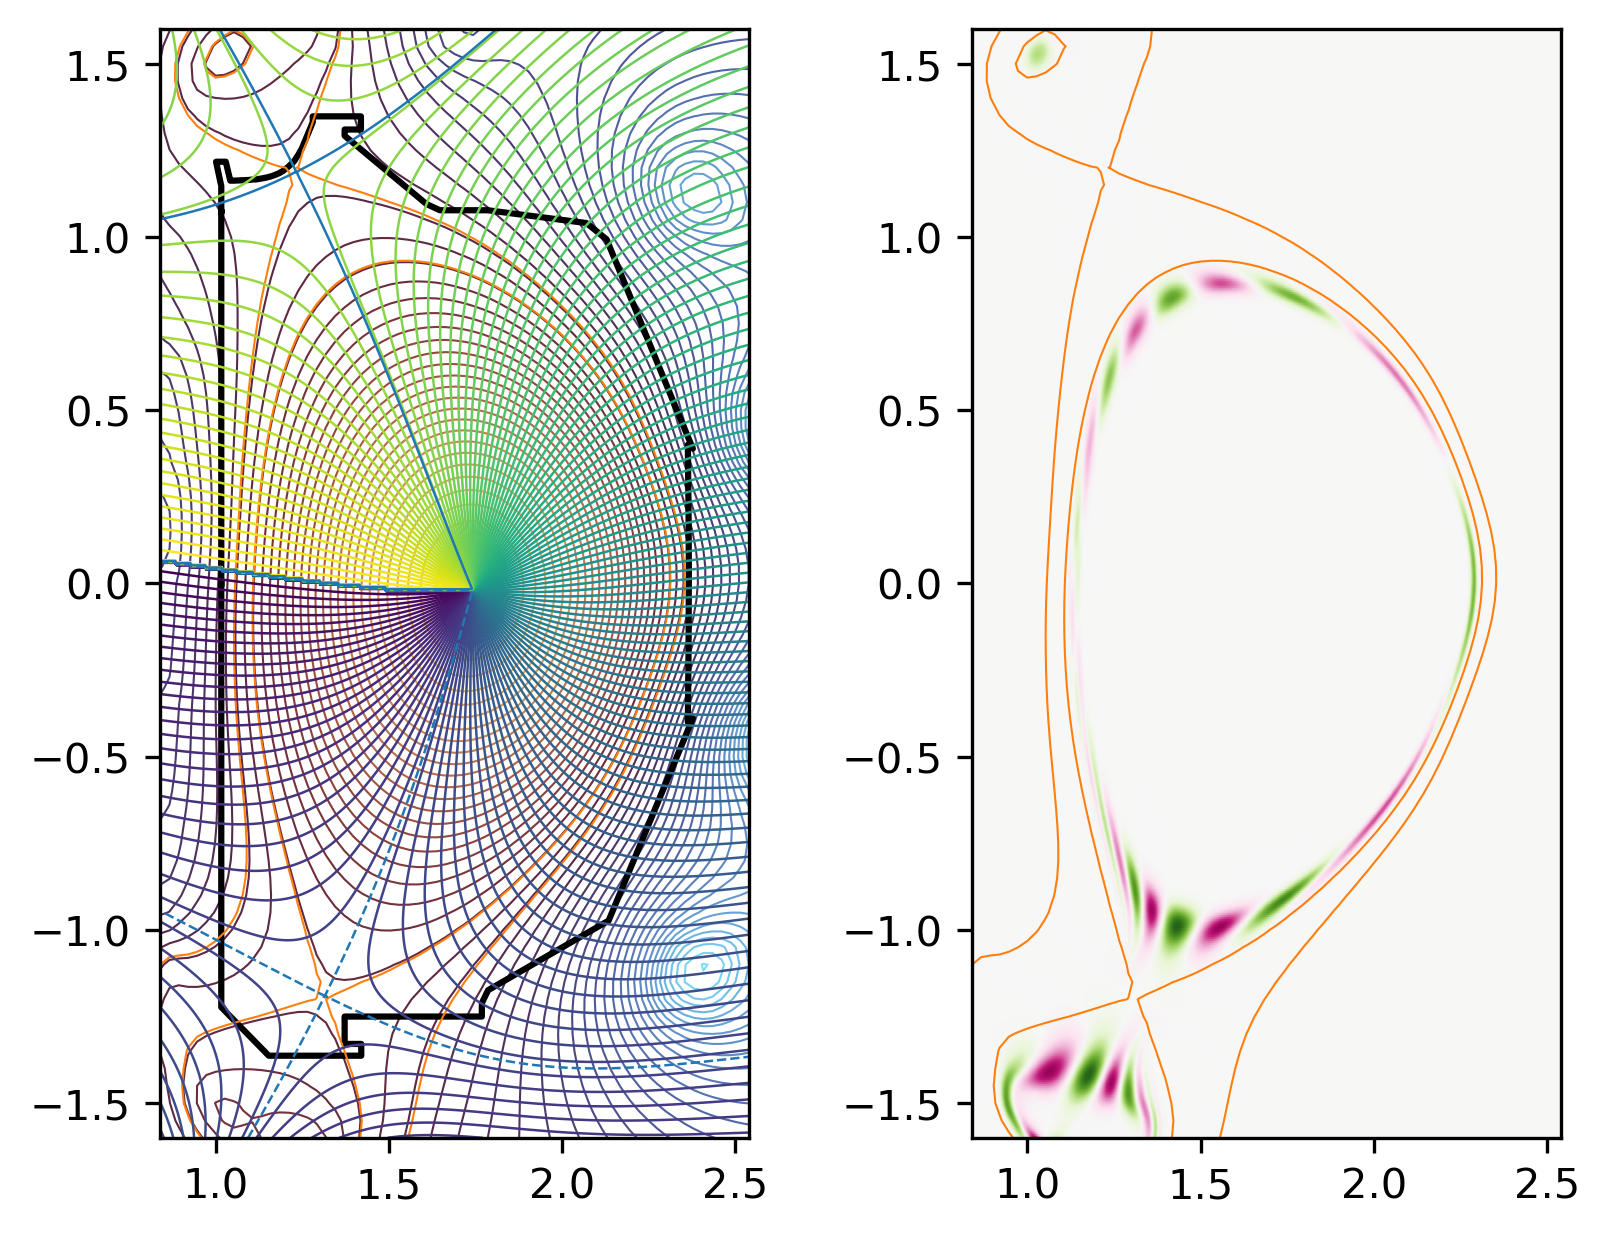

In [31]:
# %% Plot equilibrium
%matplotlib inline
plt.figure(dpi=300)
ax = plt.subplot(121)
ax2 = plt.subplot(122, sharex=ax, sharey=ax)

rgrid = np.linspace(eq.rmin, eq.rmax, 512)
zgrid = np.linspace(eq.zmin, eq.zmax, 512)
rplot, zplot = np.meshgrid(rgrid, zgrid, indexing='ij')

psi_ev, ff_ev = eq.compute_psi_and_ff(jnp.ravel(rplot), jnp.ravel(zplot))
(psi, psidr, psidz, psidrr, psidrz, psidzz) = psi_ev

#uv_y = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], 0.2, 0.0, 0.2, 0.0])
theta = theta_map(rplot.ravel(), zplot.ravel())


theta_x1 = theta_map(theta_map.nulls.x1.rz[0], theta_map.nulls.x1.rz[1])
theta_x2 = theta_map(theta_map.nulls.x2.rz[0], theta_map.nulls.x2.rz[1])


region = jnp.zeros_like(rplot.ravel())

#alpha_grid = interp_alpha(psi.ravel(), theta.ravel())
#field_grid = jnp.cos(5*alpha_grid) * jnp.exp(-0.005*alpha_grid**2) * jnp.exp(-4000*(psi.ravel() - 0.95*eq.psix)**2)

field_grid = field_provider(0.0, psi.ravel(), theta.ravel(), jnp.zeros_like(theta.ravel()))


ax.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=64, cmap='managua', linewidths=0.5)
ax.plot(eq.wallrz[0,:], eq.wallrz[1,:], c='k')
ax.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=[theta_map.nulls.x1.psi, theta_map.nulls.x2.psi], colors='tab:orange', linewidths=0.5)
ax.set_aspect('equal')
ax2.set_aspect('equal')

ax2.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=[theta_map.nulls.x1.psi, theta_map.nulls.x2.psi], colors='tab:orange', linewidths=0.5)


ax.contour(rgrid, zgrid, theta.reshape(rplot.shape).T, levels=np.linspace(-np.pi,np.pi,129), linewidths=0.6)


ax.contour(rgrid, zgrid, theta.reshape(rplot.shape).T, levels=np.sort([theta_x1, theta_x2]), linewidths=0.6, colors='tab:blue')

fmax = jnp.max(jnp.abs(field_grid[1]))
ax2.pcolormesh(rgrid, zgrid, field_grid[1].reshape(rplot.shape).T, shading='gouraud', cmap='PiYG', vmin=-1.0, vmax=1.0)




In [ ]:
# %% Initialize FieldlinePusher; this is to check the results of the clebsch mapping against fieldline tracing
fieldline_pusher = FieldlinePusher()
geom = GeometryHandler(eq, fieldline_pusher)

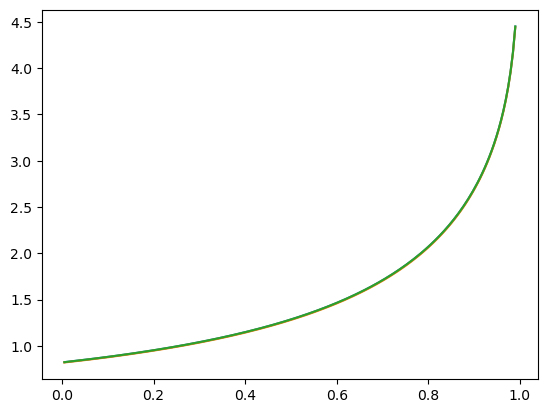

In [ ]:

plt.figure()

plt.plot(geom.psi_surf/eq.psix, -geom.q_surf)

alpha0 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, -jnp.pi))
alpha1 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, jnp.pi))

alpha2 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, 0.0))
alpha3 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, 2*jnp.pi))
plt.plot(geom.psi_surf/eq.psix, -(alpha1 - alpha0)/(2*jnp.pi))
plt.plot(geom.psi_surf/eq.psix, -(alpha3 - alpha2)/(2*jnp.pi))